In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym

from table_maker import *
from functools import partial
from itertools import *
from math import ceil

import pickle

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

$$\begin{align*}
    \mu u_t &= -u + w * f(u - a) \\
    \alpha a_t &= -a + \gamma f(u - a)
\end{align*}$$

In [97]:
with open('params00.pickle', 'rb') as f:
    param_dict = pickle.load(f)
    θ = param_dict['θ']
    α = param_dict['α']
    γ = param_dict['γ']
    μ = param_dict['μ']   

print(param_dict)

γ = .2

{'μ': 1, 'α': 5, 'γ': 1, 'θ': 0.1, 'Δ': 32.15183309100653, 'c': 3.999999999999946}


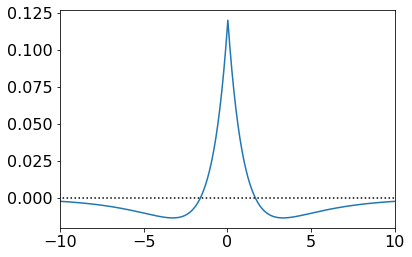

In [224]:
a, b = -30, 30
n = 10**3

###############################################
xs = np.linspace(a,b,n)
h = xs[1]-xs[0]

def firing_rate(u):
    return np.heaviside(u-θ, 1)

abs_x_sub_y = np.abs( np.subtract.outer(xs, xs) )
    
# exponetial
# M = .5*np.exp( - abs_x_sub_y ) * h

# exponetial difference
M1, M2, σ = 3, 1, 3
M = (M1*np.exp(-abs_x_sub_y) - M2*np.exp( -abs_x_sub_y/σ ))*h

# decaying absolute value
# M = (1-abs_x_sub_y) * np.exp(-abs_x_sub_y) * h


plt.plot(xs, M[n//2])
plt.plot([a, b], [0, 0], 'k:')
plt.xlim(-10, 10)
plt.show()

def convolution(u):
    return M@firing_rate(u)

def RK4_step(F, t, u, dt):
    k1 = F(t,u)
    k2 = F(t+dt/2, u + dt/2*k1)
    k3 = F(t+dt/2, u + dt/2*k2)
    k4 = F(t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

# u is a vector [u, q, a]
# F = lambda t, u: np.array([
#         1/μ * (-u[0] + M@(u[1]*firing_rate(u[0]) - u[2])),
#         (1-u[1])/α - β*u[1]*firing_rate(u[0]-u[2]),
#         (-u[2] + γ*firing_rate(u[0]-u[2]))/ϵ
#     ])
def F(t,u):
    temp = firing_rate(u[0] - u[1])
    ret = np.array([
        1/μ * (-u[0] + M@temp),
        (-u[1] + γ*temp)/α
    ])
    return ret

In [227]:
def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

In [230]:
u0 = np.zeros((2,n))
# u0[0] = cos_bell(xs, center=0, width=10)
u0[0] = u_analytic(xs, M1, M2, σ)
Δ = find_Delta(M1, M2, σ)
u0[1] = γ * (np.heaviside(xs+Δ, .5) - np.heaviside(xs - Δ, .5))

t0 = 0
t_final = 100
k = 1e-2

########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

for step in range(steps):
    ts += [ts[-1] + k]
    us += [ RK4_step(F, ts[-1], us[-1], k) ]
    print('step %d/%d' % (step,steps), end='\r')

In [231]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

stride = 20

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

line_u_exact = ax[0].plot(xs, u_analytic(xs, M1, M2, σ), 'k:', label='$u_0$')
line_u, = ax[0].plot(xs, us[0][0], 'b-', label="$u$")
line_a, = ax[0].plot(xs, us[0][1], 'm-', label="$a$")

line_j, = ax[1].plot(xs, us[0][0]-us[0][1], 'g-', label='$J$')
ax[1].plot([xs[0], xs[-1]], [θ]*2, 'k:', label='\\theta')

ax[0].set_title(f'$w(x,y) = {M1}e^{{-|x-y|}} - {M2} e^{{-|x-y|/{σ}}}$')
ax[0].legend(loc='right')
ax[0].set_ylim(*window)
ax[0].set_xlim(a, b)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_a.set_ydata(us[i][1])
    line_j.set_ydata(us[i][0] - us[i][1])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('unstable.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

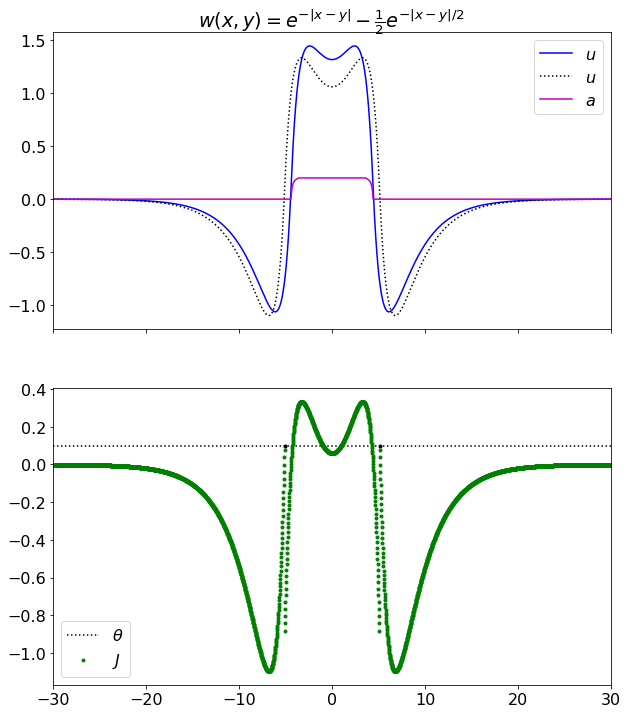

In [179]:
fig, axes = plt.subplots(2, 1, figsize=(10,12), sharex=True)

axes[0].plot(xs, us[-1][0], 'b-', label='$u$')
axes[0].plot(xs, u_analytic(xs, M1, M2, σ), 'k:', label='$u0$')
axes[0].plot(xs, us[-1][1], 'm-', label='$a$')

axes[1].plot([a, b,], [θ, θ], 'k:', label='$\\theta$')
# axes[1].plot(xs, us[-1][0] - us[-1][1], 'g-', label='$J$')
axes[1].plot(xs, u_analytic(xs, M1, M2, σ) - (np.heaviside(xs+Δ,.5) - np.heaviside(xs-Δ,.5)), 'g.', label='$J$')
axes[1].plot([-Δ, Δ], [θ,θ], 'k.')

for ax in axes:
    ax.set_xlim(a,b)
    ax.legend()
    
axes[0].set_title('$w(x,y) = e^{-|x-y|} - \\frac{1}{2} e^{-|x-y|/2}$')

# plt.savefig('test.png')
plt.show()

In [248]:
def _u_left_antiderivative(ξ, M1, M2, σ):
    return M2*σ*np.exp(-ξ/σ) - M1*np.exp(-ξ)

def _u_right(x, M1, M2, σ, Δ):
    return (  _u_left_antiderivative(x+Δ, M1, M2, σ)
            - _u_left_antiderivative(x-Δ, M1, M2, σ))

def _u_left(x, M1, M2, σ, Δ):
    xpΔ = x + Δ
    xmΔ = x - Δ
    return ( (M1*(2 - np.exp(xmΔ) - np.exp(-xpΔ)))
            +(M2*σ)*(np.exp(xmΔ/σ) + np.exp(-xpΔ/σ) - 2))

def find_Delta(M1, M2, σ):
    f = lambda Δ: σ*M2*np.exp(-2*Δ/σ) - M1*np.exp(-2*Δ) - (σ*M2 - M1 + θ + γ/2)
    df = lambda Δ: -2*M2*np.exp(-2*Δ/σ) + 2*M1*np.exp(-2*Δ)
    Δ = 5
    for _ in range(20):
        Δ -= f(Δ)/df(Δ)
    return Δ

def u_analytic(x, M1, M2, σ):
    
    Δ = find_Delta(M1, M2, σ)
    
    u = np.zeros(np.size(x))
    gteΔ_mask = x>=Δ
    u[gteΔ_mask] = _u_right(x[gteΔ_mask], M1, M2, σ, Δ)
    non_neg_mask = np.logical_and(0<=x, x<Δ) 
    u[non_neg_mask] = _u_left(x[non_neg_mask], M1, M2, σ, Δ)
    
    # u is an even function
    ltemΔ = x <= -Δ
    u[ltemΔ] = _u_right(-x[ltemΔ], M1, M2, σ, Δ)
    non_pos_mask = np.logical_and(0>=x, x>-Δ) 
    u[non_pos_mask] = _u_left(-x[non_pos_mask], M1, M2, σ, Δ)
    return u

def a_analytic(x, M1, M2, σ):
    
    Δ = find_Delta(M1, M2, σ)
    
    return γ*(np.heaviside(x+Δ, 0.5) - np.heaviside(x-Δ, 0.5))

Δ = 4.055333307155999


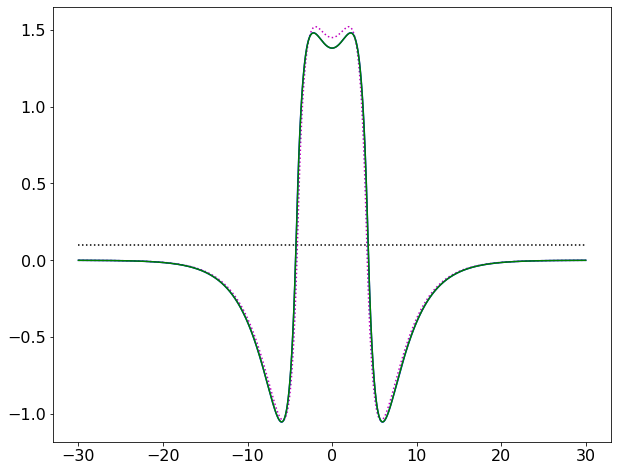

In [237]:
print(f'Δ = {find_Delta(M1, M2, σ)}')
plt.figure(figsize=(10,8))
plt.plot([a, b], [θ]*2, 'k:')
plt.plot(xs, u_analytic(xs, M1, M2, σ), 'm:')
plt.plot(xs, us[-1][0], 'b-')
plt.plot(np.linspace(a, b, len(old_u[0])), old_u[0], 'g-')
plt.show()

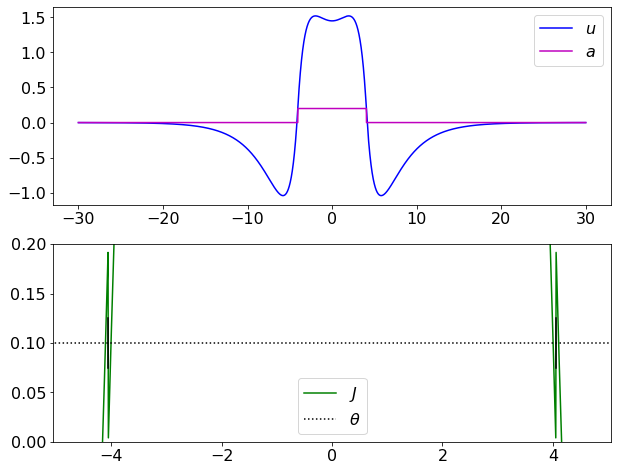

In [249]:
fig, axes = plt.subplots(2, 1, figsize=(10,8))

zs = np.linspace(a,b, 10**4)

u_exact = u_analytic(zs, M1, M2, σ)
a_exact = a_analytic(zs, M1, M2, σ)
axes[0].plot(zs, u_exact, 'b-', label='$u$')
axes[0].plot(zs, a_exact, 'm-', label='$a$')

axes[1].plot(zs, u_exact - a_exact, 'g-', label='$J$')
axes[1].plot([a,b], [θ]*2, 'k:', label='$\\theta$')
for mult in [-1, 1]:
    axes[1].plot([mult*Δ]*2, [θ-.025, θ+0.025], 'k-')

axes[1].set_xlim(-Δ-1, Δ+1)
axes[1].set_ylim(θ-.1, θ+.1)


axes[0].legend()
axes[1].legend()

# plt.savefig('crossings.png')
plt.show()